In [1]:
43 % 9

7

In [2]:
43 % 3

1

In [3]:
43 % 5

3

In [4]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from sympy import lambdify, symbols, diff
import sympy
from functools import partial

In [5]:
x_symbol = symbols('x_symbol')
x_symbol

x_symbol

In [6]:
f_symbol = 10 * x_symbol * sympy.ln(x_symbol) - x_symbol**2 / 2
f_symbol

-x_symbol**2/2 + 10*x_symbol*log(x_symbol)

In [7]:
df_symbol = diff(f_symbol, x_symbol)
df_symbol

-x_symbol + 10*log(x_symbol) + 10

In [8]:
d2f_symbol = diff(df_symbol, x_symbol)
d2f_symbol

-1 + 10/x_symbol

In [9]:
f = lambdify(x_symbol, f_symbol, 'numpy')
df = lambdify(x_symbol, df_symbol, 'numpy')
d2f = lambdify(x_symbol, d2f_symbol, 'numpy')

In [10]:
lower_bound = 0.1
upper_bound = 1.0
x0 = (lower_bound + upper_bound) / 2
eps = 1e-8

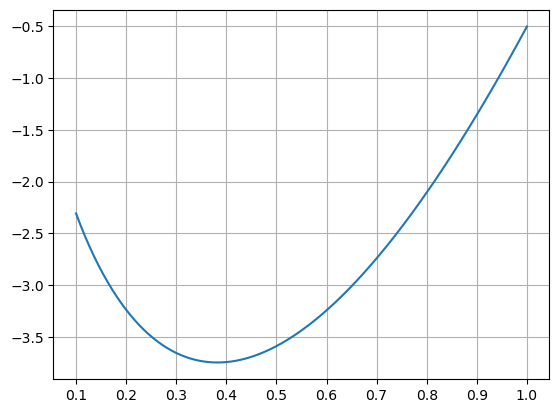

In [11]:
plt.plot((x:=np.linspace(lower_bound, upper_bound, 100)), f(x))
plt.grid(True)
plt.xticks(np.linspace(lower_bound, upper_bound, 10));

In [12]:
def plot_convergence_1d(func, x_steps, y_steps, ax, grid=None, title=""):
    """
    Функция отрисовки шагов градиентного спуска.
    Не меняйте её код без необходимости!
    :param func: функция, которая минимизируется градиентным спуском
    :param x_steps: np.array(float) — шаги алгоритма по оси Ox
    :param y_steps: np.array(float) — шаги алгоритма по оси Оу
    :param ax: холст для отрисовки графика
    :param grid: np.array(float) — точки отрисовки функции func
    :param title: str — заголовок графика
    """
    ax.set_title(title, fontsize=16, fontweight="bold")

    if grid is None:
        grid = np.linspace(np.min(x_steps), np.max(x_steps), 100)

    fgrid = [func(item) for item in grid]
    ax.plot(grid, fgrid)
    yrange = np.max(fgrid) - np.min(fgrid)

    arrow_kwargs = dict(linestyle="--", color="grey", alpha=0.4)
    for i, _ in enumerate(x_steps):
        if i + 1 < len(x_steps):
            ax.arrow(
                x_steps[i], y_steps[i],
                x_steps[i + 1] - x_steps[i],
                y_steps[i + 1] - y_steps[i],
                **arrow_kwargs
            )

    n = len(x_steps)
    color_list = [(i / n, 0, 0, 1 - i / n) for i in range(n)]
    ax.scatter(x_steps, y_steps, c=color_list)
    ax.scatter(x_steps[-1], y_steps[-1], c="red")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")

In [13]:
class LoggingCallback:
    """
    Класс для логирования шагов градиентного спуска.
    Сохраняет точку (x, f(x)) на каждом шаге.
    Пример использования в коде: callback(x, f(x))
    """
    def __init__(self):
        self.x_steps = []
        self.y_steps = []

    def __call__(self, x, y):
        self.x_steps.append(x)
        self.y_steps.append(y)

In [14]:
def plotting(axes, i, answer, title):
    if axes is not None:
        ax = axes[np.unravel_index(i, shape=axes.shape)]
        x_steps = np.array(callback.x_steps)
        y_steps = np.array(callback.y_steps)
        plot_convergence_1d(
            f, x_steps, y_steps,
            ax, grid, title
        )
        ax.axvline(answer, 0, linestyle="--", c="red",
                    label=f"true answer = {answer}")
        ax.axvline(x_steps[-1], 0, linestyle="--", c="xkcd:tangerine",
                    label=f"estimate = {np.round(x_steps[-1], 3)}")
        ax.legend(fontsize=16)

In [15]:
x0 = np.array([0.4])
res = minimize(f, x0, method='nelder-mead',
               options={'xatol': eps, 'disp': True})
print(f'min x: {res.x}, f(x) = {f(res.x)}')

Optimization terminated successfully.
         Current function value: -3.749081
         Iterations: 23
         Function evaluations: 46
min x: [0.38221242], f(x) = [-3.74908101]


In [16]:
def radix_method(func, a, b, p, eps, callback=None):
    
    if callback is None:
        callback = lambda c, v: 0
        
    k = 0
    h = (b - a) / p
    x = a
    
    func_x_prev = func(x)
    callback(x, func_x_prev)
    func_x = func(x+h)
    x += h
    callback(x, func_x)
    
    while(func_x < func_x_prev and x < b):
        func_x_prev = func_x
        x +=h
        func_x = func(x)
        callback(x, func_x)
        k += 1
    
    h = eps
    func_x_prev = func_x
    x -= h
    func_x = func(x)
    callback(x, func_x)
    
    while(func_x <= func_x_prev and x > a):
        func_x_prev = func_x
        x -= h
        func_x = func(x)
        callback(x, func_x)
        k += 1
    callback(x + h, f(x + h))
        
    return x + h, k

In [17]:
def fibonacci_numbers(max_value):

    num1, num2 = 1, 1

    if num1 > max_value:
        return
    
    yield num1

    if num2 > max_value:
        return
    
    yield num2

    while num2 < max_value:
        num1, num2 = num2, num1 + num2
        yield num2

In [18]:
def fibonacci_method(func, a, b, interval_length, eps, callback=None):
    
    if callback is None:
        callback = lambda c, v: 0
        
    max_value = (b - a) / interval_length
    fib_nums = [num for num in fibonacci_numbers(max_value)]
    length = len(fib_nums) - 1
    y = a + fib_nums[length - 2] / fib_nums[length] * (b - a)
    z = a + fib_nums[length - 1] / fib_nums[length] * (b - a)
    k = 1
    max_k = length - 3
    
    func_y, func_z = func(y), func(z)
    
    for k in range(max_k + 1):        
        if func_y <= func_z:
            less = True
            b, z = z, y
            y = a + fib_nums[length - k - 3] / fib_nums[length - k - 1] * (b - a)
            callback(b, func_z)
        else:
            less = False
            a, y = y, z
            z = a + fib_nums[length - k - 2] / fib_nums[length - k - 1] * (b - a)
            callback(a, func_y)
        func_y, func_z = (func(y), func_y) if less else (func_z, func(z))
        
    y = z
    z = y + eps
    x = (a + z) / 2 if func(y) <= func(z) else (y + b) / 2
    callback(x, func(x))
    return x, max_k + 1

In [19]:
def midpoint_method(func, dfunc, a, b, eps, callback=None):
    
    if callback is None:
        callback = lambda c, v: 0
        
    k = 0
    
    interval = b - a
    
    while interval > eps:
        x = (a + b) / 2
        dfunc_x = dfunc(x)
        callback(x, func(x))
        if dfunc_x > 0:
            b = x
        else:
            a = x
        interval /= 2
        k += 1
    return x, k

In [20]:
def newton_method(func, dfunc, d2func, x, eps, max_iter=10_000, callback=None, print_info=False):
    
    if callback is None:
        callback = lambda c, v: 0
    
    for k in range(max_iter):
        callback(x, func(x))
        dfunc_x = dfunc(x)
        d2func_x_inv = 1 / d2func(x) 
        d = -d2func_x_inv * dfunc_x
        x_prev = x
        x = x + d
        
        if np.all(abs(x - x_prev) < eps):
            callback(x, func(x))
            return x, k + 1

    if print_info:
        print('Max iterations. Stop')
    callback(x, func(x))
    return x, max_iter

In [21]:
def newton_raphson_method(func, dfunc, d2func, x, eps, lr=1.0,
                          n_eps=0.01, max_iter=10_000,
                          callback=None, print_info=False):
    
    if callback is None:
        callback = lambda c, v: 0
    
    def fi(t, x, d):
        nonlocal func
        return func(x + t * d)

    def dfi(t, x, d):
        nonlocal dfunc
        return dfunc(x + t * d)

    def d2fi(t, x, d):
        nonlocal d2func
        return d2func(x + t * d)
    k = 0
    
    for k in range(max_iter):
        callback(x, func(x))
        dfunc_x = dfunc(x)
        
        d2func_x_inv = 1 / d2func(x)
        d = -d2func_x_inv * dfunc_x 
        fi_x_d = partial(fi, x=x, d=d)
        dfi_x_d = partial(dfi, x=x, d=d)
        d2fi_x_d = partial(d2fi, x=x, d=d)

        t, _ = newton_method(fi_x_d, dfi_x_d, d2fi_x_d, lr, n_eps, max_iter=1)
        x_prev = x
        func_x_prev = func(x)
        x = x + d
        func_x = func(x)
        if np.abs(x - x_prev) < eps:
            callback(x, func(x))
            return x, k + 1

    if print_info:
        print('Max iterations. Stop')
    callback(x, func(x))
    return x, max_iter

In [22]:
def polyline_method(func, dfunc, a, b, eps, callback=None):
    if callback is None:
        callback = lambda c, v: 0
        
    L = max(np.abs(dfunc(np.linspace(lower_bound, upper_bound, 1000))))
    k = 0
    func_eval = 0

    func_a = f(a)
    func_b = f(b)
    x = 1 / 2 / L * (func_a - func_b + L * (a + b))
    p = 0.5 * (func_a + func_b + L * (a - b))
    
    callback(x, func(x))

    d = 1 / 2 / L * (f(x) - p)
    while 2 * L * d > eps:
        callback(x, func(x))
        x1 = x - d
        x2 = x + d

        func_eval += 2
        func_x1 = func(x1)
        func_x2 = func(x2)
        if func_x1 < func_x2:
            x = x1
            func_x = func_x1
        else:
            x = x2
            func_x = func_x2
        p = 0.5 * (func_x + p)
        d = 0.5 / L * (func_x - p)
        k += 1
    callback(x, func(x))
    return x, k

In [23]:
iter_number = {'radix_method': [], 'fibonacci_method': [], 'midpoint_method': [], 'newton_raphson_method': [], 'polyline_method': []}

for k in range(1, 6 + 1):
    eps = 10**(-k)
    iter_number['radix_method'].append(radix_method(f, lower_bound, upper_bound, 180*2*k, eps)[1])
    iter_number['fibonacci_method'].append(fibonacci_method(f, a=0.1, b=1, interval_length=eps, eps=eps/2)[1])
    iter_number['midpoint_method'].append(midpoint_method(f, df, lower_bound, upper_bound, eps)[1])
    iter_number['newton_raphson_method'].append(newton_raphson_method(f, df, d2f, x0, eps)[1])
    iter_number['polyline_method'].append(polyline_method(f, df, lower_bound, upper_bound, eps)[1])

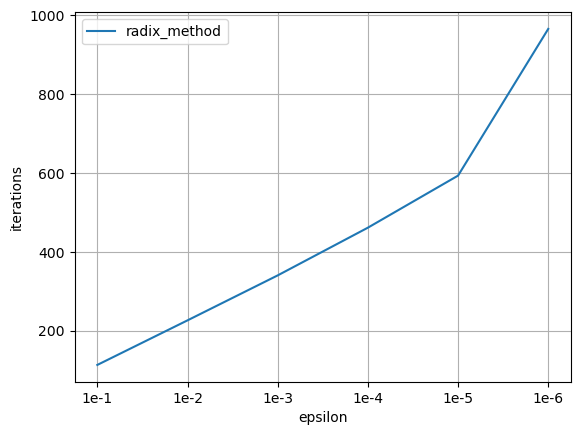

In [24]:
plt.plot(range(6), iter_number['radix_method'], label='radix_method')
plt.legend()
plt.grid(True)
plt.xlabel('epsilon')
plt.ylabel('iterations')
plt.xticks(range(6), [f'1e-{k}' for k in range(1, 7)]);

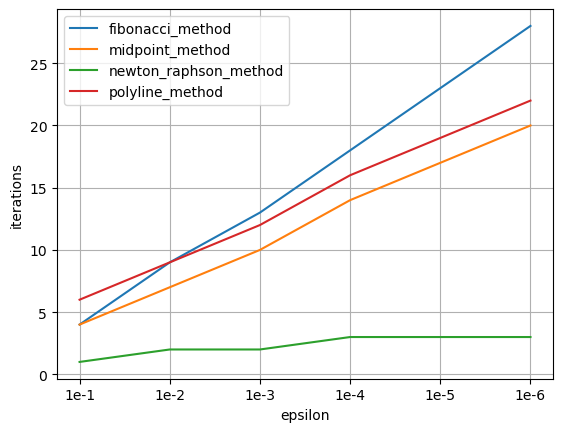

In [25]:
iter_number.pop('radix_method')

for method, iters in iter_number.items():
    plt.plot(range(6), iters, label=method)
plt.legend()
plt.grid(True)
plt.xlabel('epsilon')
plt.ylabel('iterations')
plt.xticks(range(6), [f'1e-{k}' for k in range(1, 7)]);

In [26]:
eps = 1e-4

In [27]:
xr, kr = radix_method(f, lower_bound, upper_bound, 180*2*k, eps)
xf, kf = fibonacci_method(f, a=0.1, b=1, interval_length=eps, eps=eps/2)
xm, km = midpoint_method(f, df, lower_bound, upper_bound, eps)
xn, kn = newton_raphson_method(f, df, d2f, x0, eps)
xp, kp = polyline_method(f, df, lower_bound, upper_bound, eps)

In [46]:
kr, kf, km, kn, kp

(680, 18, 14, 3, 16)

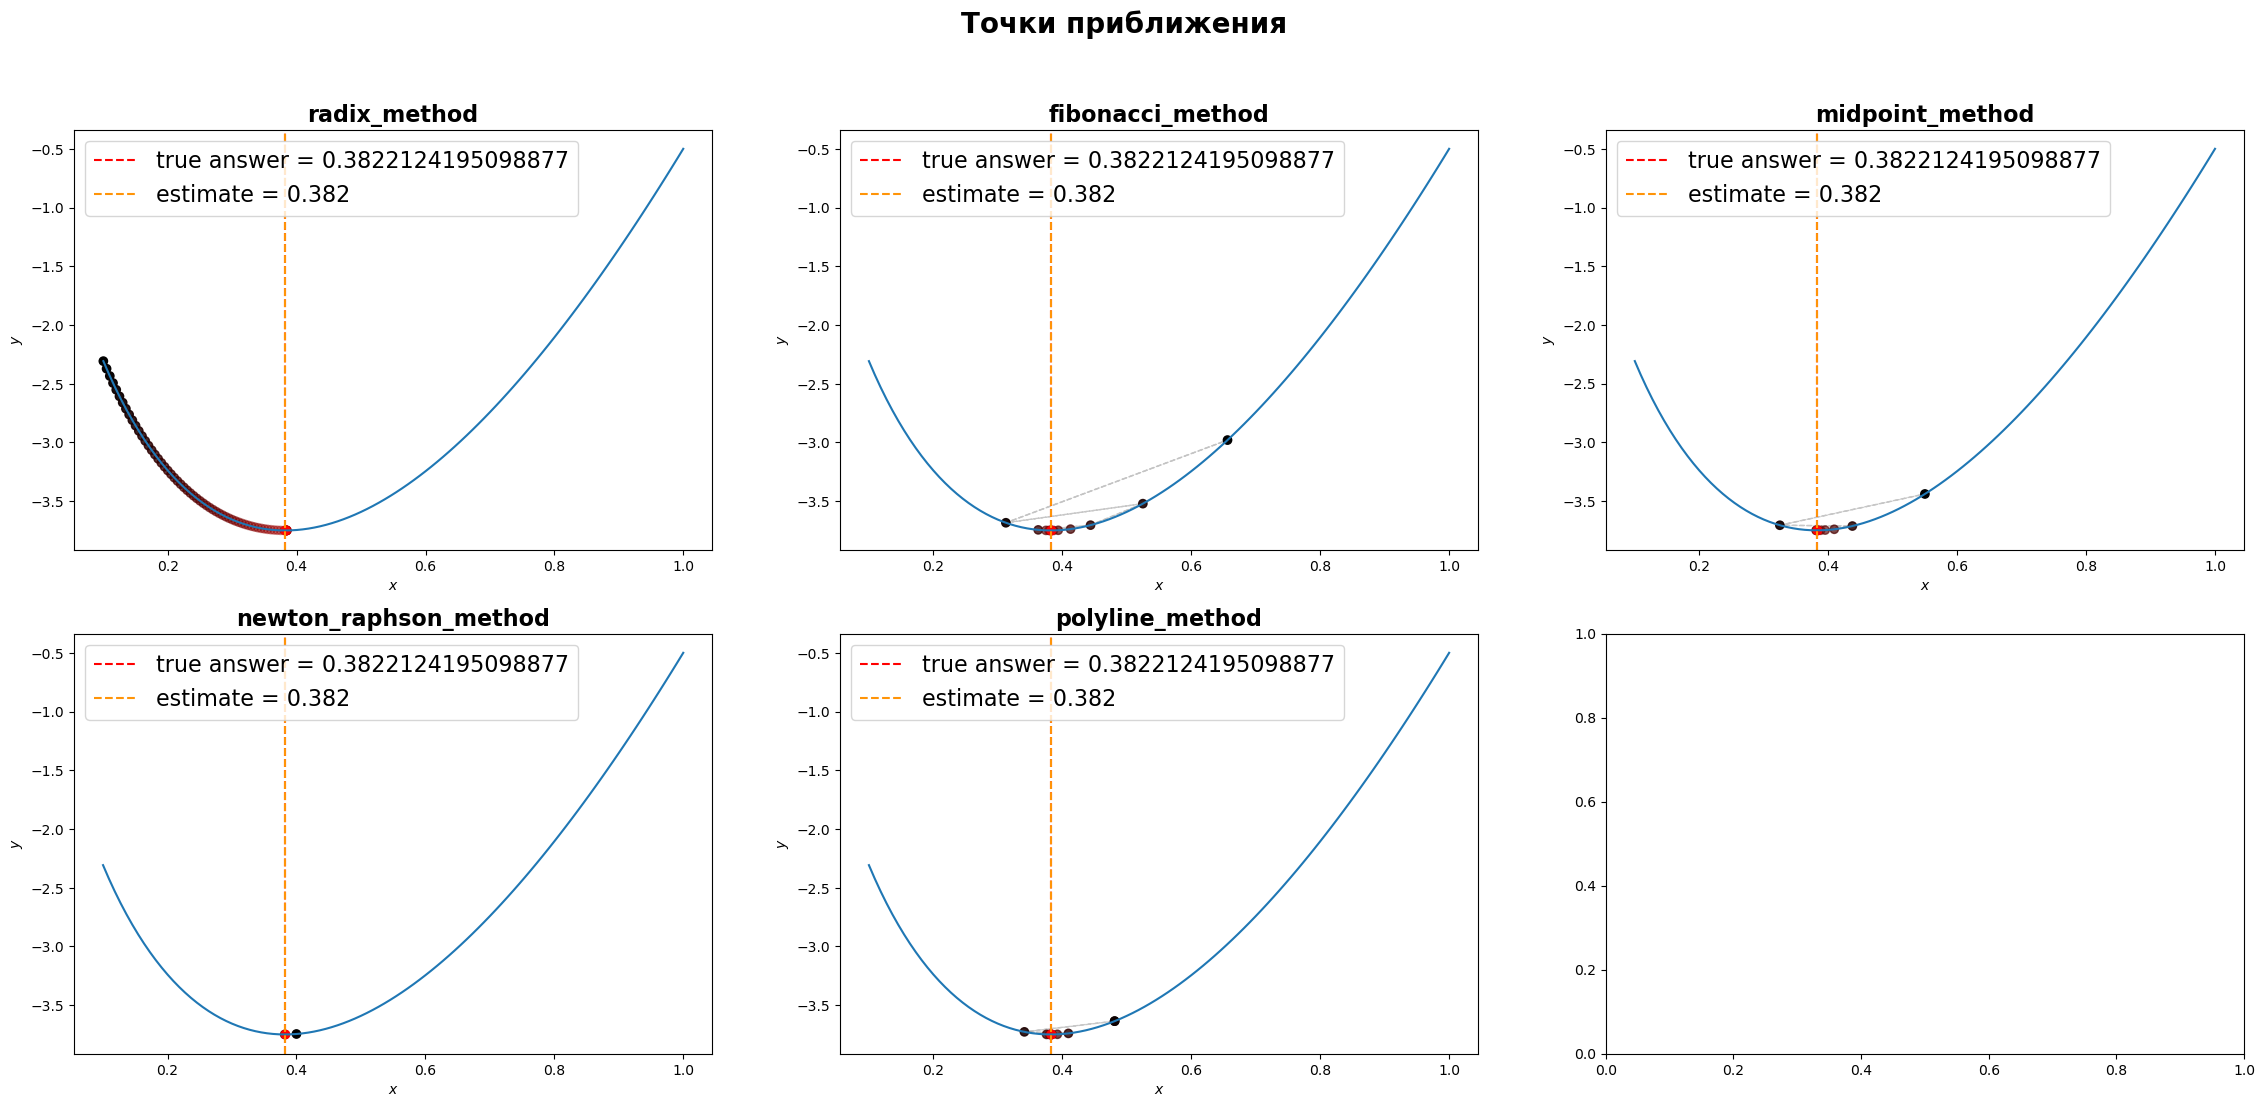

In [28]:
fig, axes = plt.subplots(2,3, figsize=(28, 12))
fig.suptitle("Точки приближения", fontweight="bold", fontsize=20)
grid = np.linspace(lower_bound, upper_bound, 100)


callback = LoggingCallback()  # Не забываем про логирование
radix_method(f, lower_bound, upper_bound, 180, eps, callback=callback)
plotting(axes, 0, res.x[0],'radix_method')

callback = LoggingCallback()
fibonacci_method(f, lower_bound, upper_bound, interval_length=eps, eps=eps/2, callback=callback)
plotting(axes, 1, res.x[0],'fibonacci_method')

callback = LoggingCallback()
midpoint_method(f, df, lower_bound, upper_bound, eps, callback=callback)
plotting(axes, 2, res.x[0],'midpoint_method')

callback = LoggingCallback()
newton_raphson_method(f, df, d2f, 0.4, eps, eps, callback=callback)
plotting(axes, 3, res.x[0],'newton_raphson_method')

callback = LoggingCallback()
polyline_method(f, df, lower_bound, upper_bound, eps, callback=callback)
plotting(axes, 4, res.x[0],'polyline_method')

In [29]:
f_symbol = sympy.exp(x_symbol) - 1 - x_symbol - x_symbol**2 / 2 - x_symbol**3 / 6
f_symbol

-x_symbol**3/6 - x_symbol**2/2 - x_symbol + exp(x_symbol) - 1

In [30]:
f = lambdify(x_symbol, f_symbol, 'numpy')

In [31]:
lower_bound = -5
upper_bound = 5
eps = 1e-4

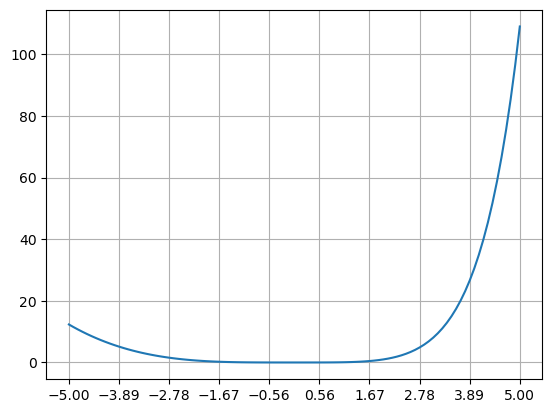

In [32]:
plt.plot((x:=np.linspace(lower_bound, upper_bound, 100)), f(x))
plt.grid(True)
plt.xticks(np.linspace(lower_bound, upper_bound, 10));

In [33]:
x0 = np.array([1])
res = minimize(f, x0, method='nelder-mead',
               options={'xatol': eps, 'disp': True})
print(f'min x: {res.x}, f(x) = {f(res.x)}')

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 35
min x: [-8.8817842e-16], f(x) = [0.]


In [34]:
radix_method(f, lower_bound, upper_bound, 400, eps)

(0.00010000000000392072, 449)

In [35]:
fibonacci_method(f, a=0.1, b=1, interval_length=eps, eps=eps/2)

(0.10006611090809428, 18)

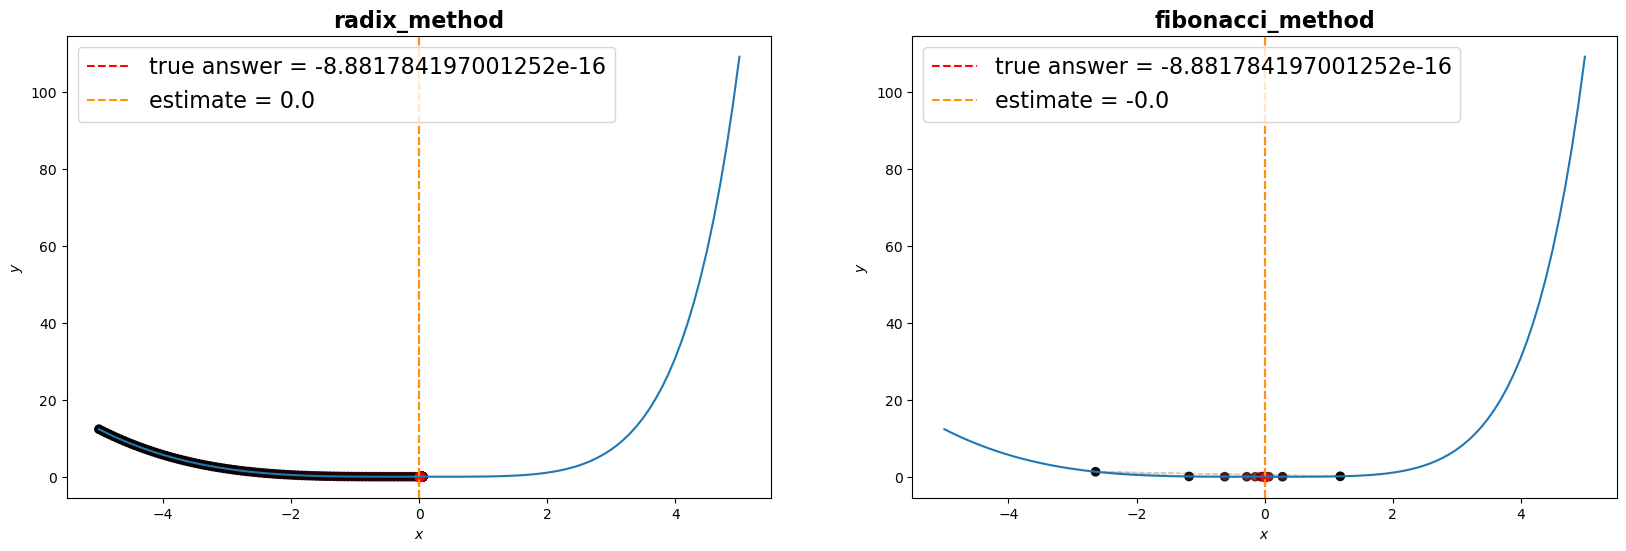

In [36]:
fig, axes = plt.subplots(1,2, figsize=(20, 6))
grid = np.linspace(lower_bound, upper_bound, 100)
callback = LoggingCallback()
radix_method(f, lower_bound, upper_bound, 180, eps, callback=callback)
plotting(axes, 0, res.x[0],'radix_method')

callback = LoggingCallback()
fibonacci_method(f, lower_bound, upper_bound, interval_length=eps, eps=eps/2, callback=callback)
plotting(axes, 1, res.x[0],'fibonacci_method')

In [37]:
f_symbol = x_symbol * sympy.atan(x_symbol) - 0.5 * sympy.log(1 + x_symbol**2)
f_symbol

x_symbol*atan(x_symbol) - 0.5*log(x_symbol**2 + 1)

In [38]:
df_symbol = diff(f_symbol, x_symbol)
df_symbol

atan(x_symbol)

In [39]:
d2f_symbol = diff(df_symbol, x_symbol)
d2f_symbol

1/(x_symbol**2 + 1)

In [40]:
f = lambdify(x_symbol, f_symbol, 'numpy')
df = lambdify(x_symbol, df_symbol, 'numpy')
d2f = lambdify(x_symbol, d2f_symbol, 'numpy')

In [41]:
lower_bound = -2
upper_bound = 2
x0 = 0
eps = 1e-4

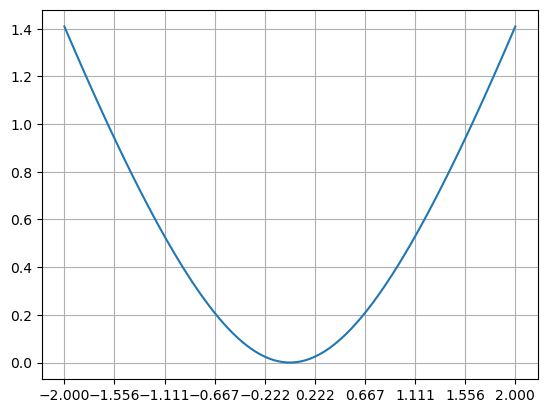

In [42]:
plt.plot((x:=np.linspace(lower_bound, upper_bound, 100)), f(x))
plt.grid(True)
plt.xticks(np.linspace(lower_bound, upper_bound, 10));

In [43]:
x0 = np.array([1])
res = minimize(f, x0, method='nelder-mead',
               options={'xatol': eps, 'disp': True})
print(f'min x: {res.x}, f(x) = {f(res.x)}')

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 34
min x: [-8.8817842e-16], f(x) = [7.88860905e-31]


In [44]:
x0 = 1
newton_raphson_method(f, df, d2f, x0, eps, eps)

(0.0, 5)

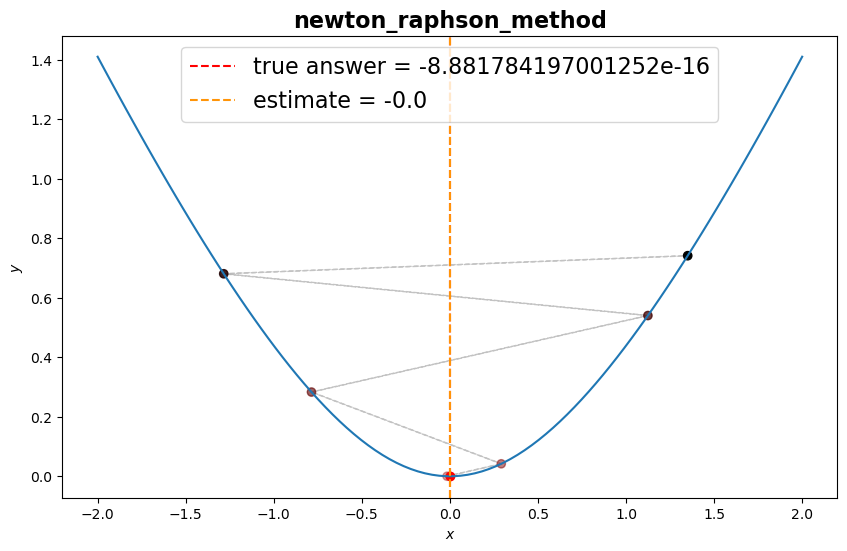

In [45]:
fig, axes = plt.subplots(figsize=(10, 6))
grid = np.linspace(lower_bound, upper_bound, 100)
callback = LoggingCallback()
newton_raphson_method(f, df, d2f, 1.35, eps, eps, callback=callback)
plotting(np.array(axes), 0, res.x[0],'newton_raphson_method')